# import

In [1]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr#

In [2]:
import pandas as pd
import numpy as np
import os
import sys
from time import time



from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants 
from astropy.coordinates import SkyCoord
from astropy.visualization import hist
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
from astroML.crossmatch import crossmatch_angular

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

import os
from collections import OrderedDict
from adjustText import adjust_text

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [5]:
from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

In [6]:
colors_10 = cm.get_cmap('tab10', 10)

In [7]:
def drop_index(data):
    data=data.reset_index(drop=True)
    return data

def drop_columns(data,column):
    data=data.drop(column,1)
    return data

## cosmology

In [8]:
from astropy.cosmology import FlatLambdaCDM,Planck13,Planck15,z_at_value
from astropy import units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
#cosmo=FlatLambdaCDM(H0=73,Om0=0.3)

## CLAGN_list_2020

CLAGN_list_2020=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/clagn_ned_list_20210201.xlsx',sheet_name='工作表1')
CLAGN_list_2020=CLAGN_list_2020[1:]

CLAGN_list_2020.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
CLAGN_list_2020=CLAGN_list_2020[CLAGN_list_2020['     RA     '].notnull()]

CLAGN_list_2020=CLAGN_list_2020.reset_index(drop=True)

CLAGN_list_2020_coord=SkyCoord(ra=CLAGN_list_2020['     RA     '], dec=CLAGN_list_2020['    DEC  '], frame='icrs')

## CLAGN_list_2021_liu

In [9]:
CLAGN_list_2021_liu=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='sources')
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]
CLAGN_list_2021_liu.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
CLAGN_list_2021_liu=CLAGN_list_2021_liu[CLAGN_list_2021_liu['RA'].notnull()]
CLAGN_list_2021_liu=CLAGN_list_2021_liu.reset_index(drop=True)
CLAGN_list_2021_liu_coord=SkyCoord(ra=CLAGN_list_2021_liu['RA'], dec=CLAGN_list_2021_liu['DEC'], frame='icrs')
CLAGN_list_2021_liu['ra_deg']=CLAGN_list_2021_liu_coord.ra.deg
CLAGN_list_2021_liu['dec_deg']=CLAGN_list_2021_liu_coord.dec.deg
CLAGN_list_2021_liu_name_pos=CLAGN_list_2021_liu[['Name','ra_deg','dec_deg']]

In [10]:
CLAGN_list_2021_liu.columns

Index(['Name', 'Unnamed: 1', 'RA', 'DEC', 'Ref.', 'Redshift', 'lg(MBH/Msun)',
       'Ref..1', 'Type', 'Note', 'Unnamed: 10', 'FIRST', 'ra_deg', 'dec_deg'],
      dtype='object')

In [11]:
len(CLAGN_list_2021_liu)

141

# FIRST

In [12]:
FIRST=fits.open('/Volumes/ExtremeSSD/Papers_Project/mwa_catalog_paper/catalog/first_14dec17.fits')

In [13]:
FIRST_data=FIRST[1].data

In [14]:
FIRST[1].data.columns

ColDefs(
    name = 'RA'; format = 'D'; unit = 'deg'
    name = 'DEC'; format = 'D'; unit = 'deg'
    name = 'SIDEPROB'; format = 'E'
    name = 'FPEAK'; format = 'E'; unit = 'mJy'
    name = 'FINT'; format = 'E'; unit = 'mJy'
    name = 'RMS'; format = 'E'; unit = 'mJy'
    name = 'MAJOR'; format = 'E'; unit = 'arcsec'
    name = 'MINOR'; format = 'E'; unit = 'arcsec'
    name = 'POSANG'; format = 'E'; unit = 'deg'
    name = 'FITTED_MAJOR'; format = 'E'; unit = 'arcsec'
    name = 'FITTED_MINOR'; format = 'E'; unit = 'arcsec'
    name = 'FITTED_POSANG'; format = 'E'; unit = 'deg'
    name = 'FLDNAME'; format = '12A'
    name = 'NSDSS'; format = 'I'
    name = 'SDSS_SEP'; format = 'E'; unit = 'arcsec'
    name = 'SDSS_MAG'; format = 'E'
    name = 'SDSS_CLASS'; format = 'A'
    name = 'NTMASS'; format = 'I'
    name = 'TMASS_SEP'; format = 'E'; unit = 'arcsec'
    name = 'TMASS_MAG'; format = 'E'
    name = 'YEAR'; format = 'E'; unit = 'year'
    name = 'MJD'; format = 'D'; unit = 'da

FIRST_coord=SkyCoord(ra=FIRST[1].data['RA'], dec=FIRST[1].data['DEC'], frame='icrs')

## crossmatch

imX = np.empty((len(CLAGN_list_2020_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2020_coord.ra.deg
imX[:, 1] = CLAGN_list_2020_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


#crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 10. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(imX, stX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 10)
plt.show()


In [ ]:
ind[match]

In [ ]:
30/141

In [ ]:
18/68

## CLAGN_list_2021_liu_coord

In [ ]:
crosslist=CLAGN_list_2021_liu_coord
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 10. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(imX, stX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 5)
plt.show()


## counts match

In [ ]:
crosslist=CLAGN_list_2021_liu_coord
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 5. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(stX, imX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 5)
plt.show()

In [ ]:
from collections import Counter
ind_remove_rep_FIRST=[]

for i in ind[match]:
    if i not in ind_remove_rep_FIRST:
        ind_remove_rep_FIRST.append(i)
        
ind_remove_rep_FIRST=np.array(ind_remove_rep_FIRST)        
a_FIRST=Counter(ind[match])

In [ ]:
a_FIRST,ind_remove_rep_FIRST

In [ ]:
CLAGN_list_2021_liu['Name'][ind_remove_rep_FIRST[np.arange(len(ind_remove_rep_FIRST))]].str.strip()

In [ ]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(111)

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(ind_remove_rep_FIRST)))

for index,i in enumerate(a_FIRST):#index 
    plt.bar(index,a_FIRST[i],color=colors[index])
    #print(index,i,a[i])
    
plt.xticks(np.arange(len(ind_remove_rep_FIRST)),CLAGN_list_2021_liu['Name'][ind_remove_rep_FIRST[np.arange(len(ind_remove_rep_FIRST))]].str.strip(),rotation=90)
#plt.title('within 5degree')
##plt.show()

## plot_flux

In [ ]:
FIRST_data_copy=FIRST_data.copy()
new_table_CLAGN=FIRST_data_copy[match]
new_index=ind[match]
#new_table_CLAGN=FIRST_data_copy.reset_index(drop=True)

In [ ]:
CLAGN_list_2021_liu_name_pos[CLAGN_list_2021_liu_name_pos['Name']=='PG 1535+547']

In [ ]:
for index,i in enumerate(new_index):
    print(index,i,CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu_name_pos['ra_deg'][i],CLAGN_list_2021_liu_name_pos['dec_deg'][i],new_table_CLAGN['FINT'][index])

for index,i in enumerate(new_index):
    print(index,i,CLAGN_list_2021_liu['Name'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])

In [ ]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(111)

for index,i in enumerate(new_index):
    plt.bar(index,new_table_CLAGN['FINT'][index])
    #print(index,i,a[i])
    plt.text(index-0.5,new_table_CLAGN['FINT'][index],'%.1f'%new_table_CLAGN['FINT'][index])
    
plt.xticks(np.arange(len(new_index)),CLAGN_list_2021_liu['Name'][new_index[np.arange(len(new_index))]].str.strip(),rotation=90)
plt.ylabel('FINT(mJy)')
#plt.title('within 5degree')
plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/Flux_FIRST_CLAGN_crossmatch.png',dpi=400,transparent=False,bbox_inches='tight')
#plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/AGN_num_within5degree.png',dpi=400,transparent=False,bbox_inches='tight')

#plt.show()

In [ ]:
CLAGN_list_2021_liu_name_pos[CLAGN_list_2021_liu_name_pos['Name']=='NGC 7469']

## format print

print('{0:>15},{1:.2f},{2:.2f},{3:.2f},{4:.1f},{5:.2f}'.format(obs_id,float(powerlawindex),float(gerr90),float(indexerr),float(bins),float(rechied))+'\n')
print('{0:.2e},{1:.2e},{2:.2e},{3:.2e}'.format(float(flux),float(ferr),float(cflux_),float(cflux_err90))+'\n')


In [ ]:
print("{0:<30},{1:<5},{2:<5},{3:<5},{4:<5},{5:<5}".format('Name','Redshift','lg(MBH/Msun)','RA','DEC','FINT'))
for index,i in enumerate(new_index):
    print("{0:<30},{1:.5f},{2:.2f},{3:.5f},{4:.5f},{5:.3F}".format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],CLAGN_list_2021_liu['lg(MBH/Msun)'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index]))
    #data_format = '{0:>15},{1:%.5f},{2:%.5f},{3:%.5f},{4:%.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])
    #print(data_format)
    #print(index,',',i,',',CLAGN_list_2021_liu['Name'][i],',',CLAGN_list_2021_liu['Redshift'][i],',',new_table_CLAGN['RA'][index],',',new_table_CLAGN['DEC'][index],',',new_table_CLAGN['FINT'][index])

for index,i in enumerate(new_index):
    #print('{0:<30},{1:.5f},{2:.5f},{3:.5f},{4:.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index]))
    data_format = '{0:<30},{1:.5f},{2:.5f},{3:.5f},{4:.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])
    print(data_format)
    #print(index,',',i,',',CLAGN_list_2021_liu['Name'][i],',',CLAGN_list_2021_liu['Redshift'][i],',',new_table_CLAGN['RA'][index],',',new_table_CLAGN['DEC'][index],',',new_table_CLAGN['FINT'][index])

## CLAGN_X-ray FLUX

### Lbol

## FIRST_flux

In [15]:
FIRST_crossmatch=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='FIRST')
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]

FIRST_crossmatch

In [17]:
D_cm=cosmo.luminosity_distance(z=FIRST_crossmatch['Redshift']).to(u.cm)
FIRST_crossmatch['D_cm']=D_cm

1Jy = 10-23erg/cm2/s/Hz

In [18]:
FIRST_crossmatch['L_INT']=4*np.pi*FIRST_crossmatch['D_cm']**2*FIRST_crossmatch['FINT']*1e-26*1.4*1e9

In [ ]:
FIRST_crossmatch.columns

In [20]:
FIRST_crossmatch_select=FIRST_crossmatch[FIRST_crossmatch['logLx'].notnull()]
FIRST_crossmatch_select=FIRST_crossmatch_select.reset_index(drop=True)

In [21]:
FIRST_crossmatch_select

,Name,Redshift,lg(MBH/Msun),RA,DEC,FINT,logLx,logLxmax,D_cm,L_INT
0,PG 1535+547,0.03893,7.34,234.16003,54.55926,1.225,42.9000,NaN,5.297759e+26,6.048648e+37
1,NGC 4051,0.00234,6.36,180.78997,44.53126,19.343,41.0379,41.5879,3.097956e+25,3.265971e+36
2,IC 751,0.03150,8.50,179.71917,42.57040,43.011,42.7000,43.7000,4.263277e+26,1.375323e+39
3,NGC 4151,0.00333,7.56,182.63563,39.40583,331.295,42.1100,42.3200,4.412000e+25,1.134550e+38
4,NGC 4395,0.00106,5.56,186.45383,33.54680,1.175,40.2301,40.3901,1.401960e+25,4.063001e+34
5,NGC 5548,0.01717,7.51,214.49783,25.13728,24.424,43.1100,43.5300,2.299058e+26,2.271195e+38
6,NGC 4388,0.00842,6.92,186.44480,12.66177,45.025,41.7800,42.6000,1.119958e+26,9.935622e+37
7,NGC 7469,0.01632,7.32,345.81503,8.87393,145.679,43.2300,43.5800,2.183839e+26,1.222295e+39
8,Mrk 530,0.02876,8.06,349.73610,0.24389,21.096,44.2391,NaN,3.884541e+26,5.600378e+38
9,Mrk 926,0.04702,8.05,346.18118,-8.68572,22.478,44.2011,NaN,6.436459e+26,1.638286e+39


In [22]:
CLAGN_statistic_plot_dir='/Volumes/ExtremeSSD/CLAGN_statistic_plot/'

In [25]:
from adjustText import adjust_text

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for i in range(len(FIRST_crossmatch)):
    if not pd.isnull(FIRST_crossmatch.iloc[i]['logLx']):      
        if pd.isnull(FIRST_crossmatch.iloc[i]['logLxmax']):
            ax.scatter(FIRST_crossmatch.iloc[i]['logLx'],np.log10(FIRST_crossmatch.iloc[i]['L_INT'])                ,
            #ec='red',fc="red",
            marker='.',   
            color='red',)
        else:

            ax.hlines(y=np.log10(FIRST_crossmatch.iloc[i]['L_INT']),
                       xmin=FIRST_crossmatch.iloc[i]['logLx'],
                       xmax=FIRST_crossmatch.iloc[i]['logLxmax'],
                       color='blue',
                       #linestyle=':'
                     )          
        ax.text(FIRST_crossmatch.iloc[i]['logLx'],
            np.log10(FIRST_crossmatch.iloc[i]['L_INT']),
            FIRST_crossmatch.iloc[i]['Name                          '])

'''texts = [ax.text(FIRST_crossmatch_select['logLx'][i], np.log10(FIRST_crossmatch_select['L_INT'][i]),
                 FIRST_crossmatch_select['Name                          '][i],fontsize=9,) for i in range(len(FIRST_crossmatch_select))]

adjust_text(texts,ax=ax,#arrowprops=dict(arrowstyle='->', color='red',lw=0.5),
            expand_text=(1.25,1.3),
            expand_points=(1.25,1.3),
            expand_objects=(1.25, 1.3),
            expand_align=(1.25, 1.3),
            autoalign='xy',
           #only_move={'points':'x', 'text':'x'}
           ) #使用adjust_text
'''
        
        
ax.set_xlabel('log LX')
ax.set_ylabel(r'log LR(1.4GHz)')

#ax.set_xlim(0.5,2.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.1, 0.8),ncol=1,loc=2,fontsize=10)

plt.savefig('%s/RX/CLAGN_RX.png'%CLAGN_statistic_plot_dir, 
            dpi=400, transparent=False, bbox_inches='tight')
plt.close()        
        

# BAT

In [28]:
BAT_105m_Seyfert=pd.read_csv('%s/BAT_105m_Seyfert.csv'%CLAGN_statistic_plot_dir)
print(BAT_105m_Seyfert.columns)

Index(['    ', '             BAT_NAME', '     RA', '    DEC', '    SNR',
       'CName', '                     OTHER_NAME', ' CTPT_RA', 'CTPT_DEC',
       '    FLUX', ' FLUX_LO', ' FLUX_HI', 'CONTA', 'GAMM', 'GAMM.1', 'GAMM.2',
       '  CHI_SQ_R', 'REDSHIF', '  LUM', 'ASSOC_STREN', '        CL2', 'Type',
       'S_type'],
      dtype='object')


In [29]:
len(BAT_105m_Seyfert)

817

## Crossmatch

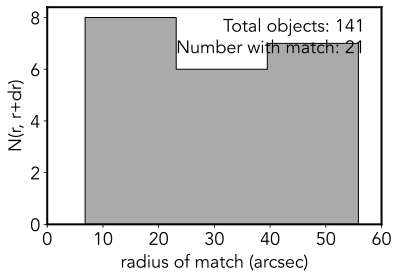

In [31]:
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(BAT_105m_Seyfert), 2), dtype=np.float64)
stX[:, 0] = pd.to_numeric(BAT_105m_Seyfert['     RA'])
stX[:, 1] = pd.to_numeric(BAT_105m_Seyfert['    DEC'])


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 60. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(stX, imX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 60)
plt.show()
plt.close()

In [32]:
from collections import Counter

ind_remove_rep_BAT=[]
for i in ind[match]:
    if i not in ind_remove_rep_BAT:
        ind_remove_rep_BAT.append(i)
        
ind_remove_rep_BAT=np.array(ind_remove_rep_BAT)        
a_BAT=Counter(ind[match])

In [ ]:
ind_remove_rep_BAT

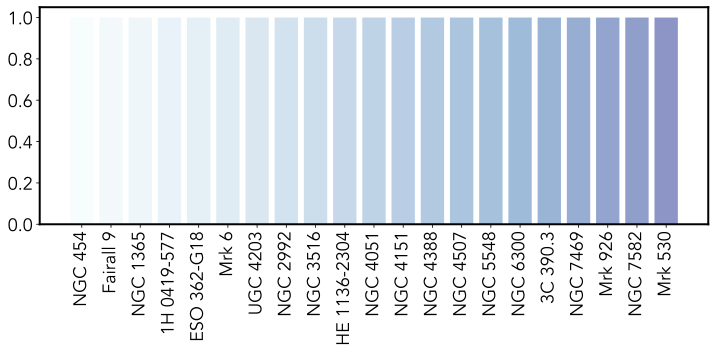

In [33]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(111)

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(ind_remove_rep_BAT)))

for index,i in enumerate(a_BAT):#index 
    plt.bar(index,a_BAT[i],color=colors[index])
    #print(index,i,a[i])
plt.xticks(np.arange(len(ind_remove_rep_BAT)),CLAGN_list_2021_liu['Name'][ind_remove_rep_BAT[np.arange(len(ind_remove_rep_BAT))]].str.strip(),rotation=90)
plt.show()
plt.close()

# CLAGN_statistic_2021_liu

In [34]:
CLAGN_statistic_2021_liu=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='statistic_paper',header=None)
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]
CLAGN_statistic_2021_liu.columns=['Name','z','type1or2','type','ref1','logM','ref2','']
#CLAGN_statistic_2021_liu
namelists_CLAGN_statistic_2021_liu=CLAGN_statistic_2021_liu['Name']

In [35]:
CLAGN_statistic_2021_liu[:5]

,Name,z,type1or2,type,ref1,logM,ref2,
0,1ES 1927+654,0.017,NaN,A,-1,7.3,(2) \\,NaN
1,1H 0419-577,0.104,Seyfert 1.5,B,-3,8.58,(4) \\,NaN
2,3C 390.3,0.056,NaN,A,-5,-,- \\,NaN
3,ESO 362-G18,0.012,NaN,A,-6,7.65,(7) \\,NaN
4,Fairall 9,0.046,NaN,A,-5,8.41,(8) \\,NaN


CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['Name']=='NGC1068']

print(len(namelists_CLAGN_statistic_2021_liu))
for i in namelists_CLAGN_statistic_2021_liu[:]:
    print(i.replace(' ',''))

## Leddrate

In [36]:
CLAGN_statistic_2021_liu_Leddrate=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec.xlsx',sheet_name='EddingtonRatio',header=0)

In [37]:
len(CLAGN_statistic_2021_liu_Leddrate)

647

In [38]:
CLAGN_statistic_2021_liu_Leddrate.columns

Index(['Name', 'Flux', 'Unnamed: 2', 'L', 'Unnamed: 4', 'F2-10', 'L2-10',
       'Flux.1', 'Unnamed: 8', 'L.1', 'Unnamed: 10', 'L5100', 'Lbol', 'MBH',
       'LEdd', 'Lbol/LEdd', 'Unnamed: 16', 'lgLbol/LEdd', 'Unnamed: 18'],
      dtype='object')

In [ ]:
CLAGN_statistic_2021_liu_Leddrate[:5]

In [39]:
for index,name in enumerate(range(len(CLAGN_statistic_2021_liu_Leddrate))):
    if isinstance(CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name'], str):    #True    
        CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']=CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']
    else:
        CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']=CLAGN_statistic_2021_liu_Leddrate.loc[index-1,'Name']

In [42]:
CLAGN_statistic_2021_liu_Leddrate[['Name','lgLbol/LEdd']][:5]

,Name,lgLbol/LEdd
0,1ES 1927+654,-1.522879
1,1ES 1927+654,-0.958607
2,1ES 1927+654,-2.230000
3,1H 0419-577,-0.559823
4,1H 0419-577,-0.659823


In [43]:
np.mean(CLAGN_statistic_2021_liu_Leddrate['lgLbol/LEdd'])

-1.9079516238276182

In [40]:
CLAGN_statistic_2021_namewith_ledd=[]
for index,i in enumerate(CLAGN_statistic_2021_liu_Leddrate['Name']):
    if i not in CLAGN_statistic_2021_namewith_ledd:
        CLAGN_statistic_2021_namewith_ledd.append(i)
        #print(i)

In [41]:
print(len(CLAGN_statistic_2021_namewith_ledd))

97


In [44]:
len(CLAGN_statistic_2021_liu)

141

# wise

from astroquery.irsa import Irsa
Irsa.list_catalogs()  

In [45]:
import os
import time
from astropy import config as _config
from astroquery.irsa import Irsa    

In [46]:
import astroquery
print(astroquery.__version__)

0.4.3


In [47]:
pwd

'/Users/brettlv/blog/brettlv.github.io/pythoncode/changinglookAGN'

In [48]:
ls

BAT_105m_catalog_07jul2019.ipynb        LLAGN_NED_name_redshift_search.ipynb
CLAGN_crossmatch.ipynb                  QSO_wise.ipynb*
CLAGN_ned_data/                         Readme.md
CLAGN_py3ads_adstex_arxiv.ipynb         Readme.py
CLAGN_wise_data/                        WISE_CLAGN_data.ipynb
CLANG_statistic_for_data_planing.ipynb  WISE_LLAGN_Quasar.ipynb
Irsa_wise_astroquery.ipynb              WISE_timelag.ipynb
Javelin_CCF_timelag.ipynb               changinglook_agn_list.ipynb


## download

In [52]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for i in CLAGN_list_2021_liu['Name']:
    #print(i)
    search_name=i.replace(' ','')
    save_name=i.strip().replace(' ','')

    if not os.path.exists('./CLAGN_wise_data/wise_%s_mep.csv'%save_name):
        try:
            print(search_name)
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120
            table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
            table_wise_mep.write('./CLAGN_wise_datawise_%s_mep.csv'%save_name, format='csv')
        except Exception:
            time.sleep(15+np.random.randint(5,10))    
    
    if not os.path.exists('./CLAGN_wise_data/wise_%s_neo.csv'%save_name):
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120

            table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
            table_wise_neo.write('./CLAGN_wise_datawise_%s_neo.csv'%save_name, format='csv')       
        except Exception:
            time.sleep(15+np.random.randint(5,10))      

for i in namelists_CLAGN_statistic_2021_liu:
    print(i)

## check notdown

In [53]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,i in enumerate(CLAGN_list_2021_liu['Name']):
    save_name=i.strip().replace(' ','')    
    search_name=i.replace(' ','')
    
    if  not os.path.exists('./CLAGN_wise_data/wise_%s_mep.csv'%save_name):
        print(index,i)
        print('***mep notdone')
        
      
    if  not os.path.exists('./CLAGN_wise_data/wise_%s_neo.csv'%save_name):
        print(index,i)
        print('***neo notdone')            

#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120
for index,i in enumerate(namelists_CLAGN_statistic_2021_liu):
    save_name=i.strip()
    new_name=save_name.replace(' ','')    
    search_name=i.replace(' ','')
    if  os.path.exists('./CLAGN_wise_data/wise_%s_mep.csv'%save_name):
        os.rename('./CLAGN_wise_data/wise_%s_mep.csv'%save_name,'./CLAGN_wise_data/wise_%s_mep.csv'%new_name)
        #print(index,i)
        #print('***mep notdone')     
    if  os.path.exists('./CLAGN_wise_data/wise_%s_neo.csv'%save_name):
        os.rename('./CLAGN_wise_data/wise_%s_neo.csv'%save_name,'./CLAGN_wise_data/wise_%s_neo.csv'%new_name)
        #print(index,i)
        #print('***neo notdone') 

# excess_variance

<span style="font-size:larger;">
$$\sigma_{rms}^2=\frac{1}{N\mu^2}\sum_{i=1}^{N}[(X_i-\mu)^2-\sigma_i^2]\\$$
</span>  



<span style="font-size:larger;">
    error on $\sigma_{rms}^2$
</span>  


<span style="font-size:larger;">
    
$$error_{\sigma_{rms}^2}=s_D/(\mu^2\sqrt{N})$$

</span>  

<span style="font-size:larger;">

$$s_D^2=\frac{1}{N-1}\sum_{i=1}^{N}\{[(X_i-\mu)^2-\sigma_i^2]-\sigma_{rms}^2\mu^2\}^2$$

</span> 

In [ ]:
def get_excess_variance(data,flux_label,fluxerr_label):

    mu=np.average(data[flux_label])
    mu_err=np.average(data[fluxerr_label])  
    len_flux=len(data[flux_label])

    sigma_rms_sqr2=np.sum((data[flux_label]-mu)**2-data[fluxerr_label]**2)/len_flux/mu**2
    
    sd_sqr2_err=np.sum(((data[flux_label]-mu)**2-data[fluxerr_label]**2-sigma_rms_sqr2*mu**2)**2)/(len_flux-1)
    sigma2_err=sd_sqr2_err**0.5/(mu**2*len_flux**0.5)
    
    sigma_rms=sigma_rms_sqr2**0.5
    sigma_rms_err=sigma2_err*0.5*sigma_rms_sqr2**-0.5
    
    return mu,mu_err,sigma_rms_sqr2,sigma2_err,sigma_rms,sigma_rms_err

mu,mu_err,sigma_rms_sqr2,sigma2_err,sigma_rms,sigma_rms_err=  get_excess_variance(df_157_src1000_large3,'int_flux','err_int_flux')  

## intrinsic amplitude of variability

In [ ]:
intrinsic amplitude of variability (σm)

<span style="font-size:larger;">
$$\Sigma=\sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(m_i-<m>)^2\\}$$
</span>  

$$\sigma_m = \begin{cases}
\sqrt{\Sigma^{2}-\epsilon^2} ,& \, \Sigma > \epsilon \\
0 , & otherwise
\end{cases}$$


$$\epsilon^2=\frac{1}{N}\sum_{i=1}^{N}\epsilon_i^2+\epsilon_s^2$$

$$\sigma_{m\, restframe}=\sigma_m \times \sqrt{(1+z)}$$

## data_test

In [ ]:
CLAGN_statistic_2021_liu['Name'][0]

In [76]:
index_test=1
name_test=CLAGN_statistic_2021_liu['Name'][index_test]
print(name_test)
save_name=name_test.strip().replace(' ','')

data_test=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)

data_test=data_test[data_test['w1mpro'].notnull()]
data_test=data_test[data_test['w2mpro'].notnull()]
data_test=data_test[data_test['w1sigmpro'].notnull()]
data_test=data_test[data_test['w2sigmpro'].notnull()]

data_test=data_test[data_test['qual_frame']>0]
data_test=data_test[data_test['cc_flags']=="b'0000'"]
data_test=data_test[data_test['nb']<3]
data_test=data_test[data_test['na']==0]


'''data_test=(data_test.loc[:, ['mjd', 'w1mpro','w2mpro',
                           'w1sigmpro','w2sigmpro',                    
                           ]].sort_values('mjd'))
'''
data_test=data_test.reset_index(drop=True)
print(len(data_test))

1H 0419-577 
482


In [65]:
data_test.columns

Index(['ra', 'dec', 'clon', 'clat', 'sigra', 'sigdec', 'sigradec', 'w1mpro',
       'w1sigmpro', 'w1snr', 'w1rchi2', 'w2mpro', 'w2sigmpro', 'w2snr',
       'w2rchi2', 'nb', 'na', 'cc_flags', 'ph_qual', 'qual_frame', 'mjd',
       'allwise_cntr', 'w1mpro_allwise', 'w1sigmpro_allwise', 'w2mpro_allwise',
       'w2sigmpro_allwise', 'w3mpro_allwise', 'w3sigmpro_allwise',
       'w4mpro_allwise', 'w4sigmpro_allwise', 'tmass_key', 'j_m_2mass',
       'j_msig_2mass', 'h_m_2mass', 'h_msig_2mass', 'k_m_2mass',
       'k_msig_2mass', 'dist', 'angle'],
      dtype='object')

In [69]:
data_test['cc_flags'][0]=="b'0000'"

True

In [ ]:
b'0000'.decode('utf-8')=='0000'

In [ ]:
and took the values of the W1 magnitude w1mpro ep, W1 magnitude error
w1sigmpro ep, W2 magnitude w2mpro ep, W2 magnitude error
w2sigmpro ep, and MJD mjd. T

len(namelists_CLAGN_statistic_2021_liu[:])

for index,i in enumerate(namelists_CLAGN_statistic_2021_liu[:]):
    print(i)

In [54]:
CLAGN_statistic_2021_liu.columns

Index(['Name', 'z', 'type1or2', 'type', 'ref1', 'logM', 'ref2', ''], dtype='object')

# CLAGN var

## neo

limit0
data=data[data['w1mpro']<15]
data=data[data['w2mpro']<13]    
#data=data[data['w1rchi2']<2]
data=data[data['qual_frame']>0]

In [ ]:
len(CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['len_neo']>50])

In [ ]:
len(CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['pearson_coeff_neo']>0.6])

## CLAGN_select_base_ledd

In [145]:
#CLAGN_select=CLAGN_statistic_2021_liu
for index,name in enumerate(CLAGN_statistic_2021_liu['Name']):    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])
        CLAGN_statistic_2021_liu.loc[index,'mean_lg(Lbol/LEdd)']=(maxleddrate+minleddrate)/2
    else: 
        CLAGN_statistic_2021_liu.loc[index,'mean_lg(Lbol/LEdd)']=np.nan
        #print(name)

## logL w1 w2

In [143]:
CLAGN_statistic_2021_liu['W1-W2']=CLAGN_statistic_2021_liu['mean_m_w1_neo']-CLAGN_statistic_2021_liu['mean_m_w2_neo']

D_cm_CLAGN_statistic_2021_liu=cosmo.luminosity_distance(z=CLAGN_statistic_2021_liu['z']).to(u.cm)
CLAGN_statistic_2021_liu['D_cm']=D_cm_CLAGN_statistic_2021_liu

CLAGN_statistic_2021_liu['logL_W1']= (-48.6-CLAGN_statistic_2021_liu['mean_m_w1_neo']+2.699)/2.5+np.log10(4*np.pi*CLAGN_statistic_2021_liu['D_cm']**2)+np.log10((constants.c/(3.4*u.um)).to(u.Hz).value)
CLAGN_statistic_2021_liu['logL_W2']= (-48.6-CLAGN_statistic_2021_liu['mean_m_w2_neo']+3.339)/2.5+np.log10(4*np.pi*CLAGN_statistic_2021_liu['D_cm']**2)+np.log10((constants.c/(4.6*u.um)).to(u.Hz).value)

In [ ]:
m(AB) = -2.5 log(f) - 48.60
3.4, 4.6, 12 and 22 microns, named W1 to W4, 

In [58]:
(constants.c/(3.4*u.um)).to(u.Hz).value

88174252352941.19

In [59]:
(constants.c/(4.6*u.um)).to(u.Hz).value

65172273478260.875

## mep

# QSO

In [38]:
QSO=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/QSO_wise_var.csv')
QSO['log(L5100)']=(QSO['lg(LHalpha)']-np.log10(5.25)-42)/1.157+44
QSO['log(Lbol)']=np.log10(9)+QSO['log(L5100)']
QSO['log(Ledd)']=np.log10(1.26*10**38)+QSO['lg(L_Mbh)']
QSO['log(Lbol/Ledd)']=QSO['log(Lbol)']-QSO['log(Ledd)']
print(QSO.columns)

Index(['Name', 'redshift', 'FWHM_Halpha', 'lg(LHalpha)', 'lg(L_Mbh)',
       'len_neo', 'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'len_mep', 'pearson_coeff_mep',
       'sigma_m_w1_mep', 'mean_m_w1_mep', 'sigma_m_w2_mep', 'mean_m_w2_mep',
       'log(L5100)', 'log(Lbol)', 'log(Ledd)', 'log(Lbol/Ledd)'],
      dtype='object')


In [39]:
D_cm_QSO=cosmo.luminosity_distance(z=QSO['redshift']).to(u.cm)
QSO['D_cm']=D_cm_QSO

QSO['logL_W1']= (-48.6-QSO['mean_m_w1_neo']+2.699)/2.5+np.log10(4*np.pi*QSO['D_cm']**2)+np.log10((constants.c/(3.4*u.um)).to(u.Hz).value)
QSO['logL_W2']= (-48.6-QSO['mean_m_w2_neo']+3.339)/2.5+np.log10(4*np.pi*QSO['D_cm']**2)+np.log10((constants.c/(4.6*u.um)).to(u.Hz).value)

In [ ]:
len(QSO)

QSO[QSO['sigma_m_w1_neo']>0.5]

In [46]:
QSO_select=QSO[QSO['len_neo']>50]
QSO_select=QSO_select[QSO_select['pearson_coeff_neo']>0]
QSO_select=drop_index(QSO_select)

In [ ]:
len(QSO_select)

# EVG

In [40]:
Extreme_QSO=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Extreme_QSO.csv')
print(Extreme_QSO.columns)

Index(['index', 'ra', 'dec', 'redshift', 'mjd_lo', 'gmag_lo', 'e_gmag_lo',
       'mjd_hi', 'gmag_hi', 'e_gmag_hi', 'fFIRST', 'Name', 'len_neo',
       'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'logLbol', 'e_logLbol', 'logBH',
       'logEdd'],
      dtype='object')


In [41]:
D_cm_Extreme_QSO=cosmo.luminosity_distance(z=Extreme_QSO['redshift']).to(u.cm)
Extreme_QSO['D_cm']=D_cm_Extreme_QSO
Extreme_QSO['logL_W1']= (-48.6-QSO['mean_m_w1_neo']+2.699)/2.5+np.log10(4*np.pi*Extreme_QSO['D_cm']**2)+np.log10((constants.c/(3.4*u.um)).to(u.Hz).value)
Extreme_QSO['logL_W2']= (-48.6-QSO['mean_m_w2_neo']+3.339)/2.5+np.log10(4*np.pi*Extreme_QSO['D_cm']**2)+np.log10((constants.c/(4.6*u.um)).to(u.Hz).value)

In [44]:
len(Extreme_QSO)

977

In [42]:
Extreme_QSO_select=Extreme_QSO[Extreme_QSO['len_neo']>50]
Extreme_QSO_select=drop_index(Extreme_QSO_select)

In [45]:
len(Extreme_QSO_select)

30

# LLAGN

LLAGN=pd.read_csv('%s/LLAGN.csv'%CLAGN_statistic_plot_dir)

## CLAGN_lightcurve

### lc crossmatch with  BAT

In [ ]:
for index_test in ind_remove_rep_BAT:
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')

    
    ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    plt.xlabel('mjd')
    plt.ylabel(r'$mag$')
    
    ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_BAT/WISE_CLAGN_lc_with_BAT_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



### lc FIRST

In [ ]:
for index_test in ind_remove_rep_FIRST:
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')

    
    ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    plt.xlabel('mjd')
    plt.ylabel(r'$mag$')
    
    ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_FIRST_lc/WISE_CLAGN_lc_with_FIRST_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



## typeB lc

In [ ]:
for index_test in range(len(typeB['Name'])):
    name_test=typeB['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    save_lc_img_path='/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN/typeB/WISE_CLAGN_lc_w1_%s.png'%save_name
    if not os.path.exists(save_lc_img_path):
    
        fig = plt.figure(figsize=(12,4))
        fig.subplots_adjust(hspace=0.0, wspace = 0.0)
        ax = fig.add_subplot(111)

        ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
        ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


        #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
        #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
              loc=2,fontsize=10)

        bottom, top = plt.ylim() 
        plt.ylim(top,bottom)

        plt.xlabel('mjd')
        plt.ylabel(r'$mag$')

        ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
        plt.savefig(save_lc_img_path,dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



## CLAGN_lc_all

In [ ]:
for index_test in range(len(CLAGN_statistic_2021_liu['Name'])):
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    save_lc_img_path='/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN/WISE_CLAGN_lc_w1_%s.png'%save_name
    if not os.path.exists(save_lc_img_path):
    
        fig = plt.figure(figsize=(12,4))
        fig.subplots_adjust(hspace=0.0, wspace = 0.0)
        ax = fig.add_subplot(111)

        ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
        ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


        #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
        #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
              loc=2,fontsize=10)

        bottom, top = plt.ylim() 
        plt.ylim(top,bottom)

        plt.xlabel('mjd')
        plt.ylabel(r'$mag$')

        ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
        plt.savefig(save_lc_img_path,dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



In [ ]:
index_test=0
name_test=CLAGN_statistic_2021_liu['Name'][index_test]
print(name_test)
search_name=name_test.replace(' ','') 
save_name=name_test

data_test_neo=pd.read_csv('wise_%s_neo.csv'%save_name)
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))

data_test_neo=data_test_neo.reset_index(drop=True)
print(data_test_neo.columns)

data_test_mep=pd.read_csv('wise_%s_mep.csv'%save_name)
data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
#data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]
    
print(len(data_test_mep))
data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                     'w1sigmpro_ep','w2sigmpro_ep',
                                     ]].sort_values('mjd'))

data_test_mep=data_test_mep.reset_index(drop=True)
print(data_test_mep.columns)


fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

#ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


#ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
      loc=2,fontsize=10)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

plt.xlabel('mjd')
plt.ylabel(r'$mag$')
plt.xlim(55365,55390)
ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)


# type A B

In [84]:
typeA=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['type'].str.contains('A')]
typeB=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['type'].str.contains('B')]

typeA=typeA.reset_index(drop=True)
typeB=typeB.reset_index(drop=True)

In [85]:
len(typeA),len(typeB)

(128, 13)

In [86]:
len(CLAGN_statistic_2021_liu)

141

In [87]:
for i in typeB['Name']:
    print(i)

1H 0419-577 
IC 751 
NGC 454 
NGC 1365 
NGC 4051 
NGC 4388 
NGC 4507 
NGC 4939 
NGC 6300 
NGC 7469 
NGC 7674 
PG 1535+547 
UGC 4203 


In [53]:
typeB

,Name,z,type1or2,type,ref1,logM,ref2,,pearson_coeff_neo,sigma_m_w1_neo,...,sigma_m_w1_mep,mean_m_w1_mep,sigma_m_w2_mep,mean_m_w2_mep,len_mep,W1-W2,D_cm,logL_W1,logL_W2,mean_lg(Lbol/LEdd)
0,1H 0419-577,0.104,Seyfert 1.5,B,-3,8.58,(4) \\,NaN,0.530280,0.017303,...,0.016404,10.830919,0.035198,9.808713,136.0,1.015444,1.481107e+27,46.674773,47.205672,-0.718023
1,IC 751,0.032,Type 2,B,-10,8.5,(10) \\,NaN,0.221433,0.025609,...,0.000000,10.728308,0.011628,9.890577,26.0,0.815431,4.332551e+26,45.653647,46.104540,-2.209823
2,NGC 454,0.012,Seyfert 2,B,-23,6.23,(24) \\,NaN,0.126139,0.048764,...,0.050122,12.521533,0.056803,12.334133,45.0,0.174619,1.600508e+26,44.040806,44.235375,NaN
3,NGC 1365,0.005,Type 1.8,B,-26,6.65,(27) \\,NaN,0.849271,0.130022,...,0.095626,7.669708,0.065198,6.920125,48.0,0.685602,6.633151e+25,45.236110,45.635072,-2.264812
4,NGC 4051,0.002,NLS 1,B,-3,6.36,(35) \\,NaN,0.941665,0.117716,...,0.047820,8.870692,0.015879,7.964269,26.0,0.803927,2.647131e+25,43.969039,44.415331,-1.766477
5,NGC 4388,0.008,Seyfert 2,B,-3,6.92,(36) \\,NaN,0.943061,0.160938,...,0.079849,9.043680,0.069195,8.029440,25.0,0.888141,1.063751e+26,45.025957,45.505934,-1.328961
6,NGC 4507,0.012,Seyfert 2,B,-37,7.65,(39) \\,NaN,0.925547,0.086324,...,0.049124,8.651943,0.047822,7.573314,35.0,1.071615,1.600508e+26,45.618677,46.172044,-2.019811
7,NGC 4939,0.010,Seyfert 2,B,-40,-,- \\,NaN,0.213567,0.203827,...,0.043787,10.042000,0.049343,9.696400,25.0,0.420715,1.331724e+26,44.988153,45.281160,NaN
8,NGC 6300,0.004,Seyfert 2,B,-43,7,(43) \\,NaN,0.699030,0.064525,...,0.062807,9.021823,0.045760,7.960583,96.0,0.892149,5.302437e+25,44.479930,44.961510,-1.844123
9,NGC 7469,0.016,Seyfert 1,B,-41,7.32,(15) \\,NaN,0.974318,0.178914,...,0.121932,8.437520,0.067355,7.638040,25.0,0.816623,2.140500e+26,46.033914,46.485284,-0.809422


## mean and sigma_m

In [ ]:
typeA.columns

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],color='red',marker='.',label='Optical_w1')
plt.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],color='black',marker='.',label='Xray_w1')

plt.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],color='red',marker='+',label='Optical_w2')
plt.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],color='black',marker='+',label='Xray_w2')

ax.legend( bbox_to_anchor=(0.5, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
set_ax_tick(ax)
plt.xlabel('mean mag')
plt.ylabel(r'$\sigma_m$')
bottom,top=plt.xlim()
plt.xlim(top,bottom)
#plt.xlim(18,0)

#ax.text(0.1, 0.9, 'w1_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],color='red',marker='.',label='Optical')
plt.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],color='black',marker='.',label='Xray')

#plt.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],color='red',marker='+')
#plt.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],color='black',marker='+',label='w2')

ax.legend( bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
plt.xlabel('mean mag w1')
plt.ylabel(r'$\sigma_m w1$')
bottom,top=plt.xlim()
plt.xlim(top,bottom)

#ax.text(0.1, 0.9, 'w1_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

### subplot

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)

size=5

ax = fig.add_subplot(221)
ax.scatter(typeA['mean_m_w1_neo'],typeA['mean_m_w2_neo'],s=size,color='red',label='Optical')
ax.scatter(typeB['mean_m_w1_neo'],typeB['mean_m_w2_neo'],s=size,color='black',label='Xray')
ax.scatter(LLAGN['mean_m_w1_neo'],LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)


ax.scatter(Extreme_QSO_select['mean_m_w1_neo'],Extreme_QSO_select['mean_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo'],QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1 (mag)')
ax.set_ylabel(r'W2 (mag)')
set_ax_tick(ax)
ax.legend( bbox_to_anchor=(0.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)




ax = fig.add_subplot(224)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['mean_m_w1_neo'],s=size,color='red',label='O')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['mean_m_w1_neo'],s=size,color='black',label='X')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['mean_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],QSO_select['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'W1')
set_ax_tick(ax)

ax = fig.add_subplot(222)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['mean_m_w2_neo'],s=size,color='red',label='O')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['mean_m_w2_neo'],s=size,color='black',label='X')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['mean_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,zorder=0)


ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'W2')

set_ax_tick(ax)
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_color_subplot.png',
            dpi=400, transparent=False, bbox_inches='tight')



In [ ]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=5
ax = fig.add_subplot(231)
x=np.linspace(0,1,10)
ax.plot(x,x,ls=':')
ax.scatter(typeA['sigma_m_w1_neo'],typeA['sigma_m_w2_neo'],s=size,color='red',label='Optical')
ax.scatter(typeB['sigma_m_w1_neo'],typeB['sigma_m_w2_neo'],s=size,color='black',label='blue')
ax.scatter(LLAGN['sigma_m_w1_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['sigma_m_w1_neo'],Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['sigma_m_w1_neo'],QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)



ax.set_xlabel(r'$\sigma_m$ w1_neo')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)
ax.legend( bbox_to_anchor=(1.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax = fig.add_subplot(232)
ax.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w2_neo'],QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)

           

ax.set_xlabel(r'W2')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)

ax = fig.add_subplot(233)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],
           Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)


ax = fig.add_subplot(235)
ax.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],s=size,color='blue')

ax.scatter(LLAGN['mean_m_w1_neo'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo'],Extreme_QSO_select['sigma_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo'],QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1')
ax.set_ylabel(r'$\sigma_m$ w1_neo')
set_ax_tick(ax)

ax = fig.add_subplot(236)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['sigma_m_w1_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['sigma_m_w1_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],
           Extreme_QSO_select['sigma_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)
ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'$\sigma_m$ w1_neo')
set_ax_tick(ax)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_subplot.png',
            dpi=400, transparent=False, bbox_inches='tight')



### sigma_m and mass

In [ ]:
typeA_mass=typeA.copy()
typeA_mass=typeA_mass[typeA['logM']!=' - ']
typeA_mass=typeA_mass.reset_index(drop=True)

typeB_mass=typeB.copy()
typeB_mass=typeB_mass[typeB['logM']!=' - ']
typeB_mass=typeB_mass.reset_index(drop=True)

In [ ]:
QSO.columns

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=7
ax = fig.add_subplot(221)
#x=np.linspace(0,1,10)
#ax.plot(x,x,ls=':')

ax.scatter(typeA_mass['logM'],typeA_mass['sigma_m_w1_neo'],
           s=size,color='red',marker='.',label='Optical')
ax.scatter(typeB_mass['logM'],typeB_mass['sigma_m_w1_neo'],
           s=size,color='blue',marker='+',label='Xray')

'''ax.scatter(typeA_mass['logM'],typeA_mass['sigma_m_w2_neo'],
           s=size,color='red',marker='*',label='O_w2')
ax.scatter(typeB_mass['logM'],typeB_mass['sigma_m_w2_neo'],
           s=size,color='black',marker='*',label='X_2')
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN_w2',zorder=0)           
'''
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(QSO['lg(L_Mbh)'],QSO['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)

for index,lmass in enumerate(Extreme_QSO_select['logBH']):
    if lmass>0:
        ax.scatter(Extreme_QSO_select.loc[index,'logBH'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'$log M_{BH}$ ')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)

#ax.legend( bbox_to_anchor=(0.01, 0.95),loc=2, numpoints=1,ncol=1,fontsize=9.)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax = fig.add_subplot(223)
ax.scatter(typeA_mass['logM'],typeA_mass['mean_m_w1_neo']-typeA_mass['mean_m_w2_neo'],
           s=size,color='red',marker='.',label='Optical')
ax.scatter(typeB_mass['logM'],typeB_mass['mean_m_w1_neo']-typeB_mass['mean_m_w2_neo'],
           s=size,color='blue',marker='+',label='Xray')

'''ax.scatter(typeA_mass['logM'],typeA_mass['mean_m_w1_neo']-typeA_mass['mean_m_w2_neo'],
           s=size,color='red',marker='*',label='O')
ax.scatter(typeB_mass['logM'],typeB_mass['mean_m_w1_neo']-typeB_mass['mean_m_w2_neo'],
           s=size,color='black',marker='*',label='X')
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
'''

ax.scatter(LLAGN['lg(MBH/Msun)'],
           LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)


ax.scatter(QSO['lg(L_Mbh)'],
           QSO['mean_m_w1_neo']-QSO['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,lmass in enumerate(Extreme_QSO_select['logBH']):
    if lmass>0:        
        ax.scatter(Extreme_QSO_select.loc[index,'logBH'],
           Extreme_QSO_select.loc[index,'mean_m_w1_neo']-Extreme_QSO_select.loc[index,'mean_m_w2_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'$log M_{BH}$ ')
ax.set_ylabel(r'$W1-W2$')
set_ax_tick(ax)



ax = fig.add_subplot(222)

ax.scatter(LLAGN['lg(Lbol/LEdd)'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO['log(Lbol/Ledd)'],QSO['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)
for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

ax_4 = fig.add_subplot(224)

ax_4.scatter(LLAGN['lg(Lbol/LEdd)'],LLAGN['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax_4.scatter(QSO['log(Lbol/Ledd)'],QSO['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax_4.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo'],
                s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax_4.set_xlabel(r'log(Lbol/Ledd)')
ax_4.set_ylabel(r'w1')
bottom,top=ax_4.set_ylim()
ax_4.set_ylim(top,bottom)
set_ax_tick(ax_4)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_subplot_mass_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')




# plot

### sigma m w1 Ledd

/Users/brettlv/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


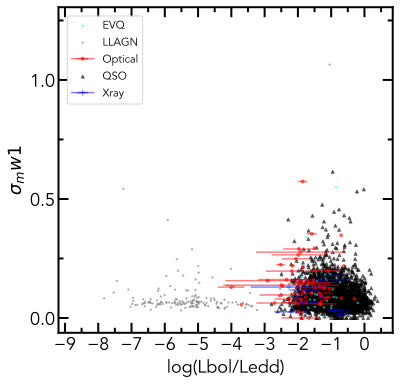

In [70]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9
ax = fig.add_subplot(111)

ax.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='^',alpha=0.5,label='QSO',zorder=0)

for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
#CLAGN_select=CLAGN_statistic_2021_liu
CLAGN_select_plot=CLAGN_select_0
for index,name in enumerate(CLAGN_select_plot['Name']):
    if CLAGN_select_plot.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])   
        ax.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select_plot.loc[index,'sigma_m_w1_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)

        
ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')



### logL_W1 sigma m w1

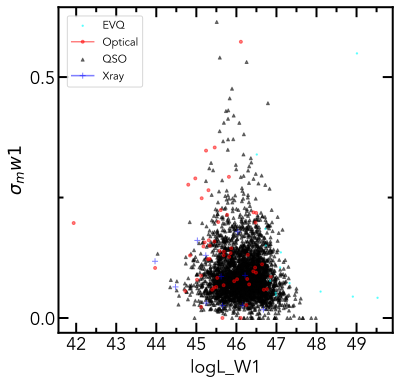

In [71]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9
ax = fig.add_subplot(111)

'''ax.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
'''
ax.scatter(QSO_select['logL_W1'],QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='^',alpha=0.5,label='QSO',zorder=0)

for index,ledd in enumerate(Extreme_QSO_select['logL_W1']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logL_W1'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
#CLAGN_select=CLAGN_statistic_2021_liu
CLAGN_select_plot=CLAGN_select_0

for index,name in enumerate(CLAGN_select_plot['Name']):
    if CLAGN_select_plot.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    ax.errorbar(x=CLAGN_select_plot.loc[index,'logL_W1'],y=CLAGN_select_plot.loc[index,'sigma_m_w1_neo'],
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)

        
ax.set_xlabel(r'logL_W1')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_logL_W1.png',
            dpi=400, transparent=False, bbox_inches='tight')



### W1-W2 Ledd

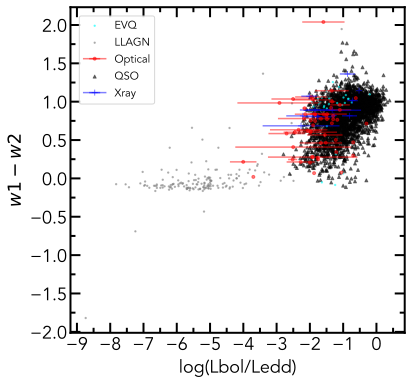

In [72]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9
ax = fig.add_subplot(111)

ax.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['mean_m_w1_neo']-LLAGN_select['mean_m_w2_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='^',alpha=0.5,label='QSO',zorder=0)

for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo']-Extreme_QSO_select.loc[index,'mean_m_w2_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
CLAGN_select_plot=CLAGN_select_0
for index,name in enumerate(CLAGN_select_plot['Name']):
    if CLAGN_select_plot.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])     
        ax.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select_plot.loc[index,'mean_m_w1_neo']-CLAGN_select_plot.loc[index,'mean_m_w2_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)

        
ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$w1-w2$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_W1-W2_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')



In [ ]:
print(len(LLAGN_select))
print(len(Extreme_QSO_select))
print(len(QSO_select))
print(len(CLAGN_select))

### w1 Leddrate

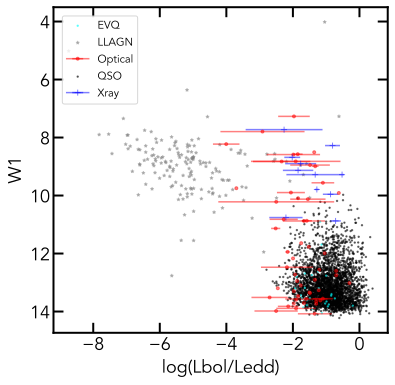

In [73]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9

ax_4 = fig.add_subplot(111)

ax_4.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax_4.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax_4.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo'],
                s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)

CLAGN_select_plot=CLAGN_select_0
for index,name in enumerate(CLAGN_select_plot['Name']):
    if CLAGN_select_plot.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])     
        ax_4.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select_plot.loc[index,'mean_m_w1_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)
        
handles, labels = ax_4.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax_4.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax_4.set_xlabel(r'log(Lbol/Ledd)')
ax_4.set_ylabel(r'W1')
bottom,top=ax_4.set_ylim()
ax_4.set_ylim(top,bottom)
set_ax_tick(ax_4)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_leddrate_w1.png',
            dpi=400, transparent=False, bbox_inches='tight')


### Lw1 Leddrate

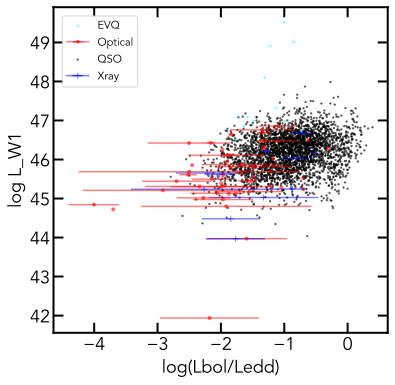

In [74]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9

ax_4 = fig.add_subplot(111)

#ax_4.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['mean_m_w1_neo'],
#           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax_4.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['logL_W1'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax_4.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'logL_W1'],
                s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)

CLAGN_select_plot=CLAGN_select_0
for index,name in enumerate(CLAGN_select_plot['Name']):
    if CLAGN_select_plot.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])    
        ax_4.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select_plot.loc[index,'logL_W1'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)
        
handles, labels = ax_4.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax_4.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax_4.set_xlabel(r'log(Lbol/Ledd)')
ax_4.set_ylabel(r'log L_W1')
#bottom,top=ax_4.set_ylim()
#ax_4.set_ylim(top,bottom)
set_ax_tick(ax_4)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_leddrate_Lw1.png',
            dpi=400, transparent=False, bbox_inches='tight')


In [ ]:
CLAGN_statistic_2021_liu_Leddrate['Name'][0].strip()==CLAGN_statistic_2021_liu['Name'][0].strip()

In [ ]:
CLAGN_statistic_2021_liu_Leddrate['Name'][0],CLAGN_statistic_2021_liu['Name'][0].strip()

## mean AB

In [75]:
np.mean(CLAGN_statistic_2021_liu['sigma_m_w1_neo']),np.mean(CLAGN_statistic_2021_liu['sigma_m_w2_neo'])

(0.13046301057673007, 0.15179745274779938)

In [77]:
np.mean(typeA['sigma_m_w1_neo']),np.mean(typeA['sigma_m_w2_neo'])

(0.1369199850014931, 0.1617815881168123)

In [79]:
np.mean(typeB['sigma_m_w1_neo']),np.mean(typeB['sigma_m_w2_neo'])

(0.09072778334741892, 0.09035661970771981)

In [80]:
np.mean(typeA['sigma_m_w1_neo']),np.mean(typeB['sigma_m_w1_neo']),

(0.1369199850014931, 0.09072778334741892)

In [81]:
np.mean(typeA['sigma_m_w2_neo']),np.mean(typeB['sigma_m_w2_neo']),

(0.1617815881168123, 0.09035661970771981)

In [83]:
np.mean(typeA['mean_m_w2_neo']),np.mean(typeB['mean_m_w2_neo']),

(11.267391022916902, 8.788707110846044)

In [84]:
np.mean(typeA['logL_W1']),np.mean(typeB['logL_W1']),

(45.65756444564119, 45.33395956410914)

In [85]:
np.mean(typeA['mean_lg(Lbol/LEdd)']),np.mean(typeB['mean_lg(Lbol/LEdd)']),

(-1.7659899800353338, -1.4212985494647845)

In [93]:
np.mean(typeA['mean_m_w1_neo']),np.mean(typeB['mean_m_w1_neo']),

(11.885398423871802, 9.627930831415851)

## type B

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)
x=np.linspace(0,0.3,10)
plt.plot(x,x)
plt.scatter(typeB['sigma_m_w1_neo'],typeB['sigma_m_w2_neo'])
plt.xlabel(r'$\sigma_m$ w1_neo')
plt.ylabel(r'$\sigma_m$ w2_neo')

In [ ]:
typeB_plot=typeB.copy()
typeB_plot=typeB_plot.reset_index(drop=True)

In [ ]:
typeB_plot

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
        
    ax.text(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['type1or2'],fontsize = 8)    
    ax.scatter(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)

ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
        
    ax2.text(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)    
    ax2.scatter(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)
    

ax.set_xlabel('mean mag')
ax.set_ylabel(r'$\sigma_m$')
ax.set_xlim(18,0)
ax2.set_xlim(18,0)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)
ax.text(0.1, 0.1, 'w1_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    ax.text(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['type1or2'],fontsize = 8)
    
    ax.scatter(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    
    ax2.text(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax2.scatter(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax.set_xlabel('mean mag')
ax.set_ylabel(r'$\sigma_m$')
ax.set_xlim(18,4)
ax2.set_xlim(18,4)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)

ax.text(0.1, 0.1, 'w2_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

### Type1or2

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    ax.text(type1or2,typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax.scatter(type1or2,typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)
    
ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    
    ax2.text(type1or2,typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax2.scatter(type1or2,typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax.set_xlabel('Type')
ax2.set_xlabel('Type')
ax.set_ylabel(r'$\sigma_m$')

ax.set_xlim(0,3)
ax2.set_xlim(0,3)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)

ax.text(0.1, 0.1, 'w1_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
ax2.text(0.1, 0.1, 'w2_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax2.transAxes, fontsize = 10)


handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

### plot_all

In [ ]:
#epsilon_s_w1=0.024
#epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for index,i in enumerate(typeB['Name']):
    type1or2=float(typeB.iloc[index]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
          
    data=pd.read_csv('wise_%s_neo.csv'%i)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data[data['qual_frame']>0]
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    x_label='w1mpro'
    xerr_label='w1sigmpro'
    y_label='w2mpro'
    yerr_label='w2sigmpro'   
    
    for d in range(len(data)):
        plt.scatter(data.iloc[d][x_label],data.iloc[d][y_label],
                color=color,marker=marker,
                label=label)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(18,6)
plt.ylim(18,6)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

In [ ]:
#epsilon_s_w1=0.024
#epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for index,i in enumerate(typeB['Name']):
    type1or2=float(typeB.iloc[index]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
          
    data=pd.read_csv('wise_%s_neo.csv'%i)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data[data['qual_frame']>0]
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    x_label='w1mpro'
    xerr_label='w1sigmpro'
    y_label='w2mpro'
    yerr_label='w2sigmpro'   
    
    for d in range(len(data)):
        plt.scatter(data.iloc[d][x_label]-data.iloc[d][y_label],data.iloc[d][x_label],
                color=color,marker=marker,s=size,
                label=label)

plt.xlabel('W1-W2')
plt.ylabel('W1')
#plt.xlim(18,6)
plt.ylim(18,6)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.6, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

# hist

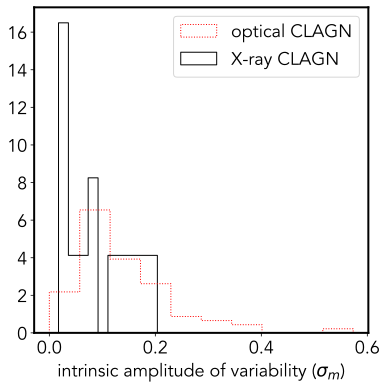

In [160]:
from astropy.visualization import hist

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.hist(typeA['sigma_m_w1_neo'],#ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'red',
         density=True,linestyle =':',
         zorder=1,histtype='step',
         label='optical CLAGN')

plt.hist(typeB['sigma_m_w1_neo'],#ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'black',
         density=True,#linestyle =':',
         zorder=0,histtype='step',
         label='X-ray CLAGN')
   
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')

ax.set_xlabel(r'intrinsic amplitude of variability ($\sigma_m$)')
plt.legend()
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_WISE_variability_w1.png', 
            dpi=400, transparent=False, bbox_inches='tight')


In [152]:
typeA_sigma_hist=typeA[typeA['len_neo']>0]
typeB_sigma_hist=typeB[typeB['len_neo']>0]
typeA_sigma_hist=drop_index(typeA_sigma_hist)
typeB_sigma_hist=drop_index(typeB_sigma_hist)

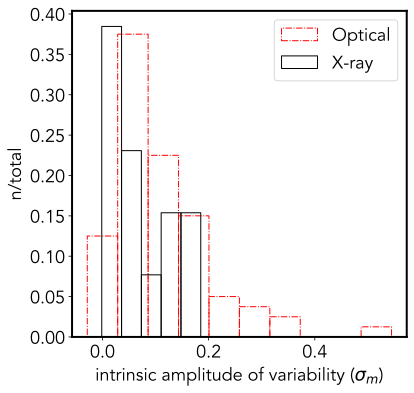

In [165]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

counts, bins = np.histogram(typeA_sigma_hist['sigma_m_w1_neo'],bins=10)
plt.bar(bins[:-1],
        counts/len(typeA_sigma_hist),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='Optical',edgecolor='red')
        
counts, bins = np.histogram(typeB_sigma_hist['sigma_m_w1_neo'],bins=5)
plt.bar(bins[:-1],
        counts/len(typeB_sigma_hist),
        bins[1]-bins[0],
        fill=False,
        label='X-ray',edgecolor='black') 

ax.set_xlabel(r'intrinsic amplitude of variability ($\sigma_m$)')
ax.set_ylabel(r'n/total')

plt.legend()
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_normal_WISE_variability_w1.png', 
            dpi=400, transparent=False, bbox_inches='tight')


In [97]:
CLAGN_statistic_2021_liu.columns

Index(['Name', 'z', 'type1or2', 'type', 'ref1', 'logM', 'ref2', '',
       'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'len_neo', 'pearson_coeff_mep',
       'sigma_m_w1_mep', 'mean_m_w1_mep', 'sigma_m_w2_mep', 'mean_m_w2_mep',
       'len_mep', 'W1-W2', 'D_cm', 'logL_W1', 'logL_W2', 'mean_lg(Lbol/LEdd)'],
      dtype='object')

In [99]:
CLAGN_statistic_2021_liu_Leddrate.columns

Index(['Name', 'Flux', 'Unnamed: 2', 'L', 'Unnamed: 4', 'F2-10', 'L2-10',
       'Flux.1', 'Unnamed: 8', 'L.1', 'Unnamed: 10', 'L5100', 'Lbol', 'MBH',
       'LEdd', 'Lbol/LEdd', 'Unnamed: 16', 'lgLbol/LEdd', 'Unnamed: 18',
       'type'],
      dtype='object')

CLAGN_statistic_2021_liu_Leddrate

In [ ]:
CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
   

In [115]:
for index,i in enumerate(CLAGN_statistic_2021_liu_Leddrate['Name']):
    data_i=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['Name'].str.strip()==i.strip()]
    if len(data_i)>0:
        CLAGN_statistic_2021_liu_Leddrate.loc[index,'type']=data_i['type'].values[0]
    #print(i,data_i['type'].values[0])


In [122]:
Leddrate_hist=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['type'].notnull()]
Leddrate_hist=drop_index(Leddrate_hist)


typeA_hist=Leddrate_hist[Leddrate_hist['type'].str.contains('A')]
typeB_hist=Leddrate_hist[Leddrate_hist['type'].str.contains('B')]

typeA_hist=typeA_hist.reset_index(drop=True)
typeB_hist=typeB_hist.reset_index(drop=True)

In [127]:
print(np.mean(typeA_hist['lgLbol/LEdd']),np.mean(typeB_hist['lgLbol/LEdd']))

-2.017940095627942 -1.3755291498213842


## ledd hist

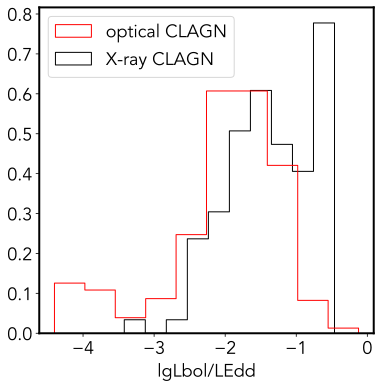

In [126]:
from astropy.visualization import hist

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.hist(typeA_hist['lgLbol/LEdd'],#ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

plt.hist(typeB_hist['lgLbol/LEdd'],#ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'black',
         density=True,
         zorder=0,histtype='step',
         label='X-ray CLAGN')
   
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')

ax.set_xlabel(r'lgLbol/LEdd')
plt.legend(loc=2)
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_lgledd_CLAGN.png', 
            dpi=400, transparent=False, bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace = 0.2)

label_bands=['W1_NEO','W2_NEO','W1_MEP','W2_MEP']
label_datas=['sigma_m_w1_neo','sigma_m_w2_neo','sigma_m_w1_mep','sigma_m_w2_mep']

for i,band in enumerate(label_bands):
    ax = fig.add_subplot(2, 2, i+1)
    
    ax.hist(typeA[label_datas[i]],
         bins=10,
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

    ax.hist(typeB[label_datas[i]],

         bins=10,
         color = 'black',
         zorder=2,histtype='step',
         label='X-ray CLAGN')
         #hist
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')
    ax.text(0.7, 0.9, label_bands[i], horizontalalignment = 'center', 
             verticalalignment = 'center', transform = ax.transAxes, fontsize = 10)

plt.xlabel(r'intrinsic amplitude of variability ($\sigma_m$)')    
plt.legend(bbox_to_anchor=(0.27, 1.8),
          loc=2, numpoints=1,ncol=1, fontsize=9.)
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_WISE_variability_subplot.png', 
            dpi=400, transparent=False, bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace = 0.2)

label_bands=['W1_NEO','W2_NEO','W1_MEP','W2_MEP']
label_datas=['sigma_m_w1_neo','sigma_m_w2_neo','sigma_m_w1_mep','sigma_m_w2_mep']

for i,band in enumerate(label_bands):
    ax = fig.add_subplot(2, 2, i+1)
    
    hist(typeA[label_datas[i]],ax=ax,
         #bins=15,
         #bins ='freedman',#blocks,scott,knuth
         bins='scott',
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

    hist(typeB[label_datas[i]],ax=ax,
         #bins=15,
         #bins ='freedman',
         bins='scott',
         color = 'black',
         density=True,
         zorder=2,histtype='step',
         label='X-ray CLAGN')
         #hist
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')
    ax.text(0.8, 0.9, label_bands[i], horizontalalignment = 'center', 
             verticalalignment = 'center', transform = ax.transAxes, fontsize = 10)
    
plt.legend(bbox_to_anchor=(0.3, 1.8),
          loc=2, numpoints=1,ncol=1, fontsize=9.)

    

# sns scatter and hist

In [ ]:
import seaborn as sns
#sns.set_theme(style="darkgrid")
#ticks
sns.set_theme(style="ticks")

In [ ]:

#LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['sigma_m_w1_neo'],

#tips = sns.load_dataset("tips")
g = sns.jointplot(x="lg(Lbol/LEdd)", y="sigma_m_w1_neo", data=LLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
plt.title('LLAGN')
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_LLAGN_sigma_m_W1_ledd')


In [ ]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
g = sns.jointplot(x="log(Lbol/Ledd)", y="log_", data=QSO_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
#plt.title('QSO')
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_QSO_sigma_m_W1_ledd')


In [ ]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
g = sns.jointplot(x="log(Lbol/Ledd)", y="sigma_m_w1_neo", data=QSO_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
#plt.title('QSO')
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_QSO_sigma_m_W1_ledd')


In [ ]:
g = sns.jointplot(x="log(Lbol/Ledd)", y="sigma_m_w1_neo", data=QSO_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
plt.text(0.5,0.8,'QSO',)

## CLAGN_select

In [ ]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
#f, ax = plt.subplots(figsize=(5, 5))
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="sigma_m_w1_neo", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_sigma_m_W1_ledd')

In [ ]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
#f, ax = plt.subplots(figsize=(5, 5))
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="W1-W2", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_W1-W2_ledd')

In [ ]:
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="logL_W1", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_LW1_ledd')

In [ ]:
g = sns.jointplot(x="logL_W1", y="sigma_m_w1_neo", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_LW1_sigma_m_w1_neo')

In [ ]:
g = sns.jointplot(x="logL_W1", y="W1-W2", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_LW1_W1-W2')

## pearsonr spearmanr

In [ ]:
pearsonr(CLAGN_select_2['mean_lg(Lbol/LEdd)'],CLAGN_select_2['sigma_m_w1_neo'])

In [ ]:
pearsonr(CLAGN_select_2['mean_lg(Lbol/LEdd)'],CLAGN_select_2['W1-W2'])

In [ ]:
pearsonr(CLAGN_select_2['logL_W1'],CLAGN_select_2['sigma_m_w1_neo'])

In [ ]:
pearsonr(CLAGN_select_2['logL_W1'],CLAGN_select_2['W1-W2'])

In [ ]:
pearsonr(CLAGN_select_2['logL_W1'],CLAGN_select_2['mean_lg(Lbol/LEdd)'])

## plt.bar

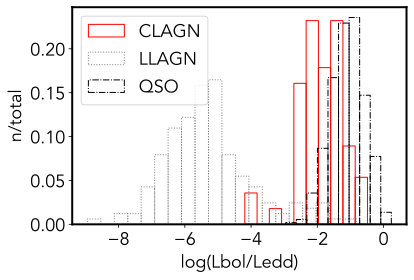

In [89]:
CLAGN_select=CLAGN_select_2
counts, bins = np.histogram(CLAGN_select['mean_lg(Lbol/LEdd)'])
plt.bar(bins[:-1],
        counts/len(CLAGN_select['mean_lg(Lbol/LEdd)']),
        bins[1]-bins[0],
        fill=False,
        label='CLAGN',edgecolor='red')


counts, bins = np.histogram(LLAGN_select['lg(Lbol/LEdd)'],bins=20)
plt.bar(bins[:-1],counts/len(LLAGN_select['lg(Lbol/LEdd)']),
        bins[1]-bins[0],
        fill=False,linestyle =':',
        label='LLAGN',edgecolor='grey')

counts, bins = np.histogram(QSO_select['log(Lbol/Ledd)'])
plt.bar(bins[:-1],counts/len(QSO_select['log(Lbol/Ledd)']),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='QSO',edgecolor='black')
plt.xlabel('log(Lbol/Ledd)')
plt.ylabel('n/total')
plt.legend()
plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_lg_ledd.png', 
            dpi=400, transparent=False, bbox_inches='tight')

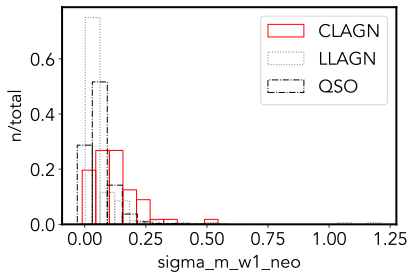

In [90]:
CLAGN_select=CLAGN_select_2
counts, bins = np.histogram(CLAGN_select['sigma_m_w1_neo'])
plt.bar(bins[:-1],
        counts/len(CLAGN_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,
        label='CLAGN',edgecolor='red')


counts, bins = np.histogram(LLAGN_select['sigma_m_w1_neo'],bins=20)
plt.bar(bins[:-1],counts/len(LLAGN_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,linestyle =':',
        label='LLAGN',edgecolor='grey')

counts, bins = np.histogram(QSO_select['sigma_m_w1_neo'])
plt.bar(bins[:-1],counts/len(QSO_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='QSO',edgecolor='black')
plt.xlabel('sigma_m_w1_neo')
plt.ylabel('n/total')
plt.legend()
plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_sigma_m_w1.png', 
            dpi=400, transparent=False, bbox_inches='tight')

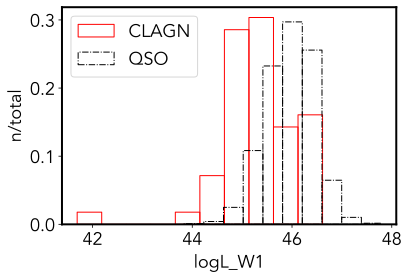

In [91]:
CLAGN_select=CLAGN_select_2
counts, bins = np.histogram(CLAGN_select['logL_W1'])
plt.bar(bins[:-1],
        counts/len(CLAGN_select['logL_W1']),
        bins[1]-bins[0],
        fill=False,
        label='CLAGN',edgecolor='red')


'''counts, bins = np.histogram(LLAGN_select['lg(Lbol/LEdd)'],bins=20)
plt.bar(bins[:-1],counts/len(LLAGN_select['lg(Lbol/LEdd)']),
        bins[1]-bins[0],
        fill=False,linestyle =':',
        label='LLAGN',edgecolor='grey')
'''
counts, bins = np.histogram(QSO_select['logL_W1'])
plt.bar(bins[:-1],counts/len(QSO_select['logL_W1']),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='QSO',edgecolor='black')
plt.xlabel('logL_W1')
plt.ylabel('n/total')
plt.legend()
plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/hist_lg_lw1.png', 
            dpi=400, transparent=False, bbox_inches='tight')